In [134]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import numpy as np

from server.signal_processing import (
    sigpro_utility,
    signal_transform,
)

In [63]:
input_nd2 = '../../data/raw_nd2/3-SR_1_5_4h_Pre-C_1h_1mMIPTG_After2h_MCM1.nd2'
input_frames = sigpro_utility.parse_nd2_file(input_nd2)


/mnt/shared/code/damp_lab/beholder/.venv/lib/python3.8/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (194047.3 ms) doesn't match the set interval (300000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)
/mnt/shared/code/damp_lab/beholder/.venv/lib/python3.8/site-packages/nd2reader/parser.py:292: UserWarning: ND2 file contains gap frames which are represented by np.nan-filled arrays; to convert to zeros use e.g. np.nan_to_num(array)
  warnings.warn('ND2 file contains gap frames which are represented by np.nan-filled arrays; to convert to zeros use e.g. np.nan_to_num(array)')


In [398]:
def purge_blank_frames(frames):
    out_list = []
    for f_index in range(0, len(frames), 3):
        grey_frame = frames[f_index]
        green_frame = frames[f_index + 1]
        red_frame = frames[f_index + 2]
        if not any(
                map(
                    sigpro_utility.empty_frame_check,
                    [grey_frame, green_frame, red_frame]
                    )
                ):
                    out_list.append(grey_frame)
                    out_list.append(green_frame)
                    out_list.append(red_frame)
        else:
            continue
    return out_list



def fetch_and_colorize(frames, f_indices):
    out_list = []
    print(f_indices)
    for f_index in f_indices:
        grey_frame, red_frame, green_frame = frames[f_index]
        if any(
                map(
                    sigpro_utility.empty_frame_check,
                    [grey_frame, green_frame, red_frame]
                )
        ):
            continue
        grey_frame = signal_transform.downsample_image(grey_frame)
        red_frame = signal_transform.downsample_image(red_frame)
        green_frame = signal_transform.downsample_image(green_frame)
        grey_frame = signal_transform.colorize_frame(grey_frame, 'grey')
        green_frame = signal_transform.colorize_frame(green_frame, 'green')
        red_frame = signal_transform.colorize_frame(red_frame, 'red')
        green_frame = signal_transform.apply_brightness_contrast(green_frame)
        red_frame = signal_transform.apply_brightness_contrast(red_frame)
        green_frame = cv2.addWeighted(green_frame, 1, green_frame, 0, 0)
        red_frame = cv2.addWeighted(red_frame, 3, red_frame, 0, 0)
        out_frame = signal_transform.combine_frame(
            grey_frame,
            red_frame,
            beta=0.1,
        )
        out_frame = signal_transform.combine_frame(
            out_frame,
            green_frame,
            beta=0.1,
        )
        out_frame = cv2.addWeighted(out_frame, 3, out_frame, 0, 10)
        out_list.append(out_frame)
    return out_list

def fetch_and_histogram(frames, f_indices):
    out_list = []
    for f_index in f_indices:
        green_frame = frames[f_index + 1]
        red_frame = frames[f_index + 2]
        # green_frame = green_frame * 2
        # red_frame = red_frame * 2
        g_hist, g_bins = np.histogram(green_frame, bins=15)
        freq=2000000
        g_hist[np.where(g_hist >= freq)] = 0
        g_width = 0.8 * (g_bins[1] - g_bins[0])
        g_center = (g_bins[:-1] + g_bins[1:]) / 2
        r_hist, r_bins = np.histogram(red_frame, bins=15)
        freq=2000000
        r_hist[np.where(r_hist >= freq)] = 0
        r_width = 0.8 * (r_bins[1] - r_bins[0])
        r_center = (g_bins[:-1] + g_bins[1:]) / 2
        out_list.append([
            [g_hist, g_bins, g_width, g_center],
            [r_hist, r_bins, r_width, r_center]]
        )
    return out_list

def fetch_and_compare(frames, f_indices):
    out_list = []
    for f_index in f_indices:
        green_frame = frames[f_index + 1]
        red_frame = frames[f_index + 2]
        green_med = np.sum(green_frame)
        red_med = np.sum(red_frame)
        out_list.append([green_med, red_med])
    return out_list



def generate_frame_and_hist_subplot(
        frames,
        time_indicies,
        title,
        time_series_titles,
):
    fig = plt.figure(figsize=(13, 6))
    canvas = FigureCanvasAgg(fig)
    grid = plt.GridSpec(3, 5, hspace=0.4, wspace=0.02)
    plt.title(f'{title}', fontsize=16, y=1.10)
    # Frame Specification
    frame_1 = fig.add_subplot(grid[0, 0])
    frame_2 = fig.add_subplot(grid[0, 1])
    frame_3 = fig.add_subplot(grid[0, 2])
    frame_4 = fig.add_subplot(grid[0, 3])
    frame_5 = fig.add_subplot(grid[0, 4])
    ax_frame_list = [frame_1, frame_2, frame_3, frame_4, frame_5]
    col_frame_list = fetch_and_colorize(frames, time_indicies)
    f_iter = zip(ax_frame_list, col_frame_list, time_series_titles)
    for axis, frame, title in f_iter:
        axis.imshow(frame, interpolation='nearest')
        axis.set_title(title)
        plt.axis('off')
        axis.set_xticklabels([])
        axis.set_yticklabels([])
        axis.set_aspect('equal')
    # Histogram Specification
    hist_1 = fig.add_subplot(grid[1, 0])
    hist_2 = fig.add_subplot(grid[1, 1])
    hist_3 = fig.add_subplot(grid[1, 2])
    hist_4 = fig.add_subplot(grid[1, 3])
    hist_5 = fig.add_subplot(grid[1, 4])
    ts_1 = fig.add_subplot(grid[2, :])
    ax_hist_list = [hist_1, hist_2, hist_3, hist_4, hist_5]
    # time_series_titles = ['1', '2', '3', '4', '5']
    hist_list = fetch_and_histogram(frames, time_indicies)
    h_iter = zip(ax_hist_list, hist_list, time_series_titles)
    for axis, hist, title in h_iter:
        green_hist_stats = hist[0]
        red_hist_stats = hist[1]
        g_hist, g_bins, g_width, g_center = green_hist_stats
        r_hist, r_bins, r_width, r_center = red_hist_stats
        r1 = np.arange(len(g_hist))
        r2 = [x + g_width for x in r1]
        # print(g_center)
        r_center = [pos + (g_width/2) for pos in r_center]
        axis.set_ylim(0, 1800000)
        axis.bar(
            g_center,
            g_hist,
            width=g_width/2,
            color='green',
            alpha=0.8,
        )
        axis.bar(
            r_center,
            r_hist,
            width=r_width/2,
            color='red',
            alpha=0.8,
        )
        # axis.set_xticklabels([])
        # axis.set_yticklabels([])
        axis.set_title(title)
    for ax in fig.get_axes():
        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    hist_1.tick_params(bottom=True, labelbottom=True, left=True, labelleft=True)
    hist_1.set_ylabel('Frequency')
    hist_2.tick_params(bottom=True, labelbottom=True, left=False, labelleft=False)
    hist_3.tick_params(bottom=True, labelbottom=True, left=False, labelleft=False)
    hist_4.tick_params(bottom=True, labelbottom=True, left=False, labelleft=False)
    hist_5.tick_params(bottom=True, labelbottom=True, left=False, labelleft=False)
    hist_1.set_yticklabels([
        '0',
        '1/4',
        '1/2',
        '3/4',
        '1',
        ]
    )
    t_iter = fetch_and_compare(frames, time_indicies)
    ts_1.set_prop_cycle(color=['green', 'red'])
    ts_1.plot(time_indicies, t_iter)
    ts_1.grid(True)
    ts_1.tick_params(bottom=True, labelbottom=True, left=True, labelleft=True)
    ts_1.set_ylabel('Intensity')
    ts_1.set_xlim(570, 600)
    ts_1.set_yticklabels([
        '1.25',
        '1.50',
        '1.75',
        '2.0',
        '2.25'
        ]
    )
    ts_1.set_xticklabels([
        '0h',
        '',
        '3.25h',
        '',
        '9.75h',
        '',
        '13h',
    ])
    # hist_3.set_title('Histogram Distribution', y=-0.1)
    plt.savefig('test.jpg', dpi=300)
    plt.show()

846
[570, 575, 580, 590, 600]


<ipython-input-398-2d60839fa81c>:168: UserWarning: FixedFormatter should only be used together with FixedLocator
  hist_1.set_yticklabels([
<ipython-input-398-2d60839fa81c>:183: UserWarning: FixedFormatter should only be used together with FixedLocator
  ts_1.set_yticklabels([
<ipython-input-398-2d60839fa81c>:191: UserWarning: FixedFormatter should only be used together with FixedLocator
  ts_1.set_xticklabels([


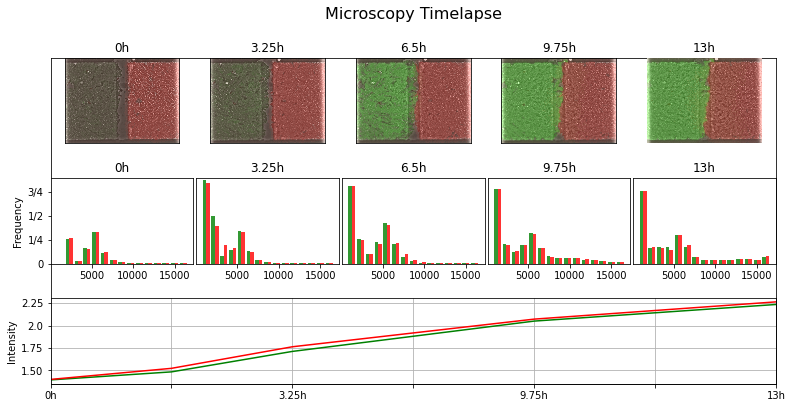

In [399]:
time_series_points = [570, 575, 580, 590, 600]
# time_series_points = [450, 550, 650, 750, 840]
time_points = ['0h', '3.25h', '6.5h', '9.75h', '13h']
input_frames = purge_blank_frames(input_frames)
generate_frame_and_hist_subplot(input_frames, time_series_points, 'Microscopy Timelapse', time_points)
